In [49]:
import pickle
from tqdm import tqdm, trange
from torch.autograd import Variable
import scipy.ndimage as nd
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch
import tqdm
import time
import os
import wandb
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from PIL import Image

from external_utils import format_time
from utils.data_preprocessing import preprocess_dataset_get_data_loader, generate_merged_dataset_from_two_loader, generate_dataset_from_loader,preprocess_mnist_fmnist,get_data_loader
from structure.dlgn_conv_config_structure import DatasetConfig
from collections import OrderedDict

from visualization import recreate_image, save_image,  PerClassDataset
from utils.data_preprocessing import true_segregation
from structure.generic_structure import CustomSimpleDataset
from adversarial_attacks_tester import generate_adv_examples

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)

from keras.datasets import mnist, fashion_mnist

from conv4_models import get_model_instance, get_model_instance_from_dataset,Conv4_DLGN_Net_pad_k_1_wo_bn_wo_bias

In [4]:
from collections import OrderedDict

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [22]:
def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


In [23]:
def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)

In [24]:
def recreate_np_image(recreated_im, unnormalize=False, is_standarize_01=True):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [0.4914, 0.4822, 0.4465]
    reverse_std = [1/0.2023, 1/0.1994, 1/0.2010]
    if(is_standarize_01):
        arr_max = np.amax(recreated_im)
        arr_min = np.amin(recreated_im)
        recreated_im = (recreated_im-arr_min)/(arr_max-arr_min)

    if(unnormalize):
        for c in range(3):
            recreated_im[c] /= reverse_std[c]
            recreated_im[c] -= reverse_mean[c]
    # recreated_im[recreated_im > 1] = 1
    # recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im)
    # print("recreated_im shape", recreated_im.shape)
    # print("recreated_im", recreated_im)
    # recreated_im = recreated_im..transpose(1, 2, 0)
    return recreated_im


In [25]:
def gallery(array, nrows, ncols):
    if(nrows is None or ncols is None):
        return array
    if(len(array.shape) == 3):
        nindex, height, width = array.shape
        nrows = nindex//ncols
        assert nindex == nrows*ncols
        # want result.shape = (height*nrows, width*ncols, intensity)
        result = (array.reshape(nrows, ncols, height, width)
                  .swapaxes(1, 2)
                  .reshape(height*nrows, width*ncols))
        return result
    elif(len(array.shape) == 4):
        nrows, ncols, height, width = array.shape

        result = (array.swapaxes(1, 2)
                  .reshape(height*nrows, width*ncols))

        return result


In [26]:
def determine_row_col_from_features(num_features):
    current_row = int(math.sqrt(num_features))
    if(num_features % current_row == 0):
        return current_row, num_features//current_row

    interval = 1
    while(interval < num_features):
        backward = current_row - interval
        if(num_features % backward == 0):
            return backward, num_features//backward
        interval += 1
    return 0, 0

In [27]:
def generate_plain_image_data(image_data):
    row = None
    col = None
    if(isinstance(image_data, torch.Tensor)):
        image_data = torch.squeeze(image_data)
        image_data = copy.copy(image_data.cpu().clone().detach().numpy())
    else:
        image_data = np.squeeze(image_data)
    if(len(image_data.shape) == 3):
        row, col = determine_row_col_from_features(image_data.shape[0])
    elif(len(image_data.shape) == 4):
        row, col = determine_row_col_from_features(
            image_data.shape[0]*image_data.shape[1])

    reshaped_data = gallery(image_data, row, col)

    return reshaped_data

In [28]:
def plt_imshow(npimg):
    plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=True)
    print("npimg size",npimg.shape)
    if(len(npimg.shape) == 2):
      npimg = np.expand_dims(npimg,axis=0)
    if(npimg.shape[0]<=3):
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      plt.show()

In [29]:
def imshow(img,ratio=2):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    aspect_ratio = img.shape[0] / img.shape[1]
    new_width = int(img.shape[1]*ratio)
    new_height = int(new_width * aspect_ratio)
    print("img size",img.shape)
    if isinstance(img, (np.ndarray, np.generic,torch.Tensor)):
        if isinstance(img, torch.Tensor):
          img = format_np_output(img.numpy())
        else:
          img = format_np_output(img)
        print("img size after formatting",img.shape)
        img = Image.fromarray(img)
    print("(new_width,new_height)",(new_width,new_height))
    img = img.resize((new_width,new_height),resample=Image.BICUBIC)
    img.show()

In [30]:
def get_plain_image(image_data, is_standarize=True, is_standarize_01=True):
    # print("image_data", image_data.shape)
    # print("image_data len", len(image_data.shape))

    reshaped_data = generate_plain_image_data(image_data)

    reshaped_data = recreate_np_image(
        reshaped_data, is_standarize, is_standarize_01)
    return reshaped_data

In [31]:
def generate_plain_image(image_data, save_path, is_standarize=True, is_standarize_01=True):
    # print("image_data", image_data.shape)
    # print("image_data len", len(image_data.shape))

    reshaped_data = generate_plain_image_data(image_data)

    reshaped_data = recreate_np_image(
        reshaped_data, is_standarize, is_standarize_01)
    save_image(reshaped_data, save_path)

In [32]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output

    def close(self):
        self.hook.remove()

In [41]:
dataset = "mnist"
model_arch_type = 'dlgn__conv4_dlgn_pad_k_1_st1_bn_wo_bias__'
batch_size = 64

is_analysis_on_train = False

torch_seed = 2022

# None means that train on all classes
list_of_classes_to_train_on = None
# list_of_classes_to_train_on = [4, 9]

# Percentage of information retention during PCA (values between 0-1)
pca_exp_percent = None
custom_dataset_path = None

In [42]:
if(dataset == "cifar10"):
    inp_channel = 3
    classes = ('plane', 'car', 'bird', 'cat',
                'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    num_classes = len(classes)

    cifar10_config = DatasetConfig(
        'cifar10', is_normalize_data=False, valid_split_size=0.1, batch_size=batch_size, 
        list_of_classes=list_of_classes_to_train_on,custom_dataset_path=custom_dataset_path)

    trainloader, _, testloader = preprocess_dataset_get_data_loader(
        cifar10_config, model_arch_type, verbose=1, dataset_folder="./Datasets/", is_split_validation=False)

elif(dataset == "mnist"):
    inp_channel = 1
    classes = [str(i) for i in range(0, 10)]
    num_classes = len(classes)

    ds_config = DatasetConfig(
        'mnist', is_normalize_data=True, valid_split_size=0.1, batch_size=batch_size, 
        list_of_classes=list_of_classes_to_train_on,custom_dataset_path=custom_dataset_path)

    trainloader, _, testloader = preprocess_dataset_get_data_loader(
        ds_config, model_arch_type, verbose=1, dataset_folder="./Datasets/", is_split_validation=False)

elif(dataset == "fashion_mnist"):
    inp_channel = 1
    classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle-boot')
    num_classes = len(classes)

    ds_config = DatasetConfig(
        'fashion_mnist', is_normalize_data=True, valid_split_size=0.1, batch_size=batch_size, 
        list_of_classes=list_of_classes_to_train_on,custom_dataset_path=custom_dataset_path)

    trainloader, _, testloader = preprocess_dataset_get_data_loader(
        ds_config, model_arch_type, verbose=1, dataset_folder="./Datasets/", is_split_validation=False)


In [35]:
device = "cuda"
batch_size=1

In [53]:
def plot_filters_single_channel(t):

    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12

    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)

    count = 0
    fig = plt.figure(figsize=(ncols, nrows))

    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.tight_layout()
    plt.show()

def plot_filters_multi_channel(t):

    #get the number of kernals
    num_kernels = t.shape[0]

    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels

    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))

    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)

        #for each kernel, we convert the tensor to numpy
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.savefig('myimage.png', dpi=100)
    plt.tight_layout()
    plt.show()

def plot_weights(layerObj, single_channel = True, collated = False):

  #getting the weight tensor data
  weight_tensor = layerObj.weight.data

  if single_channel:
    if collated:
      plot_filters_single_channel_big(weight_tensor)
    else:
      plot_filters_single_channel(weight_tensor)

  else:
    if weight_tensor.shape[1] == 3:
      plot_filters_multi_channel(weight_tensor)
    else:
      print("Can only plot weights with three channels with single channel = False")


In [44]:
def show_imshow(img, title):

  """Custom function to display the image using matplotlib"""

  #define std correction to be made
  std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)

  #define mean correction to be made
  mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)

  #convert the tensor img to numpy img and de normalize
  npimg = np.multiply(img.cpu().numpy(), std_correction) + mean_correction

  #plot the numpy image
  plt.figure(figsize = (batch_size * 4, 4))
  plt.axis("off")
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()


In [89]:

# with open('root/model/save/mnist/adversarial_training/MT_dlgn__conv4_dlgn_pad_k_1_st1_bn_wo_bias___ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.06/batch_size_128/eps_stp_size_0.06/adv_steps_80/dlgn__conv4_dlgn_pad_k_1_st1_bn_wo_bias__/RAW_WEIGHT_ANALYSIS/AP_MERGED_WEIGHTS/dump.pkl', 'rb') as f:
with open("root/model/save/mnist/CLEAN_TRAINING/ST_2022/dlgn__conv4_dlgn_pad_k_1_st1_bn_wo_bias__/RAW_WEIGHT_ANALYSIS/AP_MERGED_WEIGHTS/dump.pkl", 'rb') as f:
    loaded_dict = pickle.load(f)

In [90]:
key_list = list(loaded_dict["or_weights"].keys())
tmpd = [(i,key_list[i]) for i in range(len(key_list))]
tmpd

[(0, 'conv1_g'), (1, 'conv2_g'), (2, 'conv3_g'), (3, 'conv4_g')]

In [91]:
merged_weights_in_each_layer = loaded_dict["or_weights"]
o_f_outs_DFT_norms = loaded_dict["or_fouts"]
o_merged_padded_fouts = loaded_dict["or_merged_fouts"]
transformed_weights = loaded_dict["mr_weights"]
mm_f_outs_DFT_norms = loaded_dict["mr_fouts"]
mm_merged_padded_fouts = loaded_dict["mr_merged_fouts"]
top_pca_components = loaded_dict["topcomp_weights"]
top_pcacomp_f_outs_DFT_norms = loaded_dict["topcomp_fouts"]
top_pcacomp_merged_padded_fouts = loaded_dict["topcomp_merged_fouts"]

In [92]:

# temp_model = torch.load('root/model/save/mnist/adversarial_training/MT_dlgn__conv4_dlgn_pad_k_1_st1_bn_wo_bias___ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.06/batch_size_128/eps_stp_size_0.06/adv_steps_80/adv_model_dir.pt', map_location=device)
temp_model = torch.load('root/model/save/mnist/CLEAN_TRAINING/ST_2022/dlgn__conv4_dlgn_pad_k_1_st1_bn_wo_bias___dir.pt', map_location=device)
# custom_model = st1_pad1_vgg16_bn_wo_bias()
custom_model = Conv4_DLGN_Net_pad_k_1_wo_bn_wo_bias(input_channel=1,seed=2022,num_classes=10)
if(isinstance(temp_model, dict)):
    if("module." in [*temp_model['state_dict'].keys()][0]):
        new_state_dict = OrderedDict()
        for k, v in temp_model['state_dict'].items():
            name = k[7:]  # remove 'module.' of dataparallel
            new_state_dict[name] = v
        custom_model.load_state_dict(new_state_dict)
    else:
        custom_model.load_state_dict(temp_model['state_dict'])
else:
    custom_model.load_state_dict(temp_model.state_dict())

custom_model = custom_model.to(device)
custom_model.eval()

Conv4_DLGN_Net_pad_k_1_wo_bn_wo_bias(
  (conv1_g): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
  (conv2_g): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
  (conv3_g): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
  (conv4_g): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
  (conv1_w): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
  (conv2_w): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
  (conv3_w): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
  (conv4_w): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)

img size (28, 28)
img size after formatting (28, 28, 3)
(new_width,new_height) (280, 280)


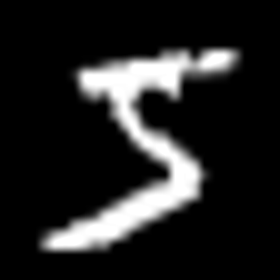

y 5


In [93]:
x,y = next(iter(trainloader))
sample = torch.squeeze(x[0],0)
sample = sample.type(next(custom_model.parameters()).dtype)
sample = (sample - sample.min() ) / ( sample.max() - sample.min())
# imshow(np.transpose(sample.numpy(), (1, 2, 0)),ratio=10)
imshow(sample.numpy(),ratio=10)
print("y",classes[y[0]])

In [94]:
diff_lists=[]
pca_comp_outs = []
pcacomp_conv_arr = []

In [95]:
for layer_ind in range(len(key_list)):
  layer_name = key_list[layer_ind]
  cur_weight=merged_weights_in_each_layer[layer_name]
  cur_we_dft = o_f_outs_DFT_norms[layer_ind]
  cur_pca_weight = torch.tensor(transformed_weights[layer_name])
  cur_pca_we_dft = mm_f_outs_DFT_norms[layer_ind]
  cur_pca_we_mrgd_dft = mm_merged_padded_fouts[layer_ind]
  cur_pca_comp = torch.Tensor(top_pca_components[layer_name])
  cur_pcacomp_dft = top_pcacomp_f_outs_DFT_norms[layer_ind]
  cur_pca_comp = np.transpose(cur_pca_comp, (1, 0))
  cur_pca_comp = np.reshape(
    cur_pca_comp, (cur_pca_comp.shape[0], cur_weight.size()[1], cur_weight.size()[2], cur_weight.size()[3]))
  padding=cur_weight.size()[3]-1
  out_capturer = SaveFeatures(custom_model.get_gate_layers_ordered_dict()[layer_name])
  effective_conv = torch.nn.Conv2d(cur_weight.size()[0], cur_weight.size()[1], kernel_size=(cur_weight.size()[2], cur_weight.size()[3]), stride=1, padding=padding,bias=False)
  effective_conv.weight = torch.nn.Parameter(cur_weight)
  effective_conv = effective_conv.to(device)
  pcacomp_conv = torch.nn.Conv2d(cur_pca_comp.size()[0], cur_pca_comp.size()[1], kernel_size=(cur_pca_comp.size()[2], cur_pca_comp.size()[3]), stride=1, padding=padding,bias=False)
  pcacomp_conv.weight = torch.nn.Parameter(cur_pca_comp)
  pcacomp_conv = pcacomp_conv.to(device)
  minput = torch.unsqueeze(sample,0)
  minput = torch.unsqueeze(minput,0)
  custom_model(minput.to(device))
  org_out = out_capturer.features.detach().cpu()[0]
  # print("org_out",org_out.size())
  # img_org_out = get_plain_image(org_out,is_standarize=False)
  # imshow(img_org_out,ratio=5)
  eff_out = effective_conv(minput.to(device))
  eff_out.size()
  diff_lists.append((org_out - eff_out.cpu()).abs().sum())
  # img_eff_out = get_plain_image(eff_out,is_standarize=False)
  # imshow(img_eff_out,ratio=5)
  pcacomp_eff_out = pcacomp_conv(minput.to(device))
  print("{} layer_name: {} cur_weight.size():{},cur_pca_weight.size():{},cur_pca_comp.size():{} pcacomp_eff_out.size():{}".format(layer_ind,layer_name,cur_weight.size(),cur_pca_weight.size(),cur_pca_comp.size(),pcacomp_eff_out.size()))
  img_pcacomp_eff_out = get_plain_image(pcacomp_eff_out,is_standarize=False)
  pca_comp_outs.append(img_pcacomp_eff_out)
  pcacomp_conv_arr.append(pcacomp_conv)

0 layer_name: conv1_g cur_weight.size():torch.Size([128, 1, 3, 3]),cur_pca_weight.size():torch.Size([128, 1, 2, 4]),cur_pca_comp.size():torch.Size([8, 1, 3, 3]) pcacomp_eff_out.size():torch.Size([1, 8, 30, 30])
1 layer_name: conv2_g cur_weight.size():torch.Size([128, 1, 5, 5]),cur_pca_weight.size():torch.Size([128, 1, 2, 4]),cur_pca_comp.size():torch.Size([8, 1, 5, 5]) pcacomp_eff_out.size():torch.Size([1, 8, 32, 32])
2 layer_name: conv3_g cur_weight.size():torch.Size([128, 1, 7, 7]),cur_pca_weight.size():torch.Size([128, 1, 2, 4]),cur_pca_comp.size():torch.Size([8, 1, 7, 7]) pcacomp_eff_out.size():torch.Size([1, 8, 34, 34])
3 layer_name: conv4_g cur_weight.size():torch.Size([128, 1, 9, 9]),cur_pca_weight.size():torch.Size([128, 1, 2, 4]),cur_pca_comp.size():torch.Size([8, 1, 9, 9]) pcacomp_eff_out.size():torch.Size([1, 8, 36, 36])


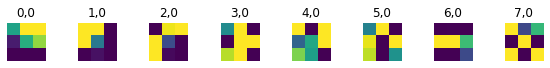

In [96]:
plot_weights(pcacomp_conv_arr[0].cpu(),single_channel = True)

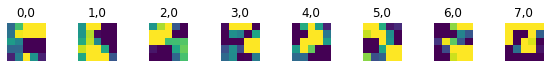

In [97]:
plot_weights(pcacomp_conv_arr[1].cpu(),single_channel = True)

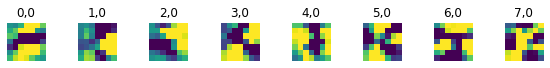

In [98]:
plot_weights(pcacomp_conv_arr[2].cpu(),single_channel = True)

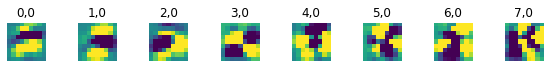

In [99]:
plot_weights(pcacomp_conv_arr[3].cpu(),single_channel = True)

img size (60, 120)
img size after formatting (60, 120, 3)
(new_width,new_height) (600, 300)


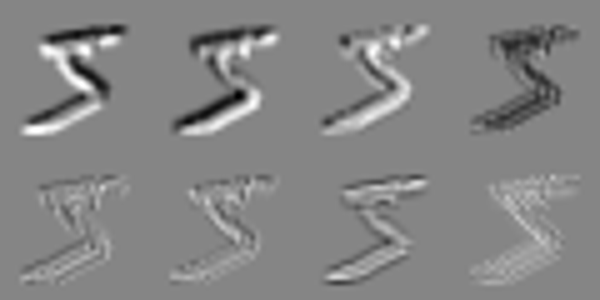

img size (64, 128)
img size after formatting (64, 128, 3)
(new_width,new_height) (640, 320)


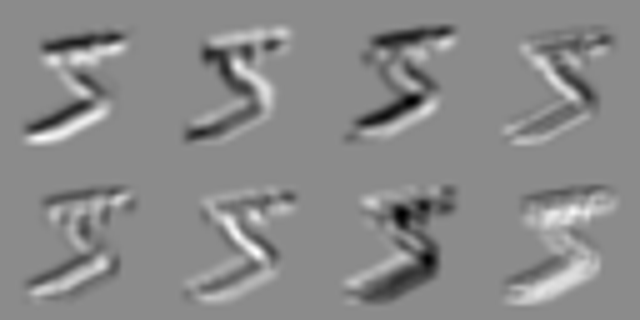

img size (68, 136)
img size after formatting (68, 136, 3)
(new_width,new_height) (680, 340)


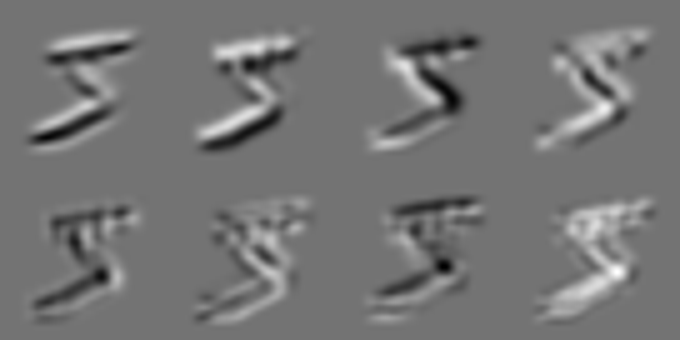

img size (72, 144)
img size after formatting (72, 144, 3)
(new_width,new_height) (720, 360)


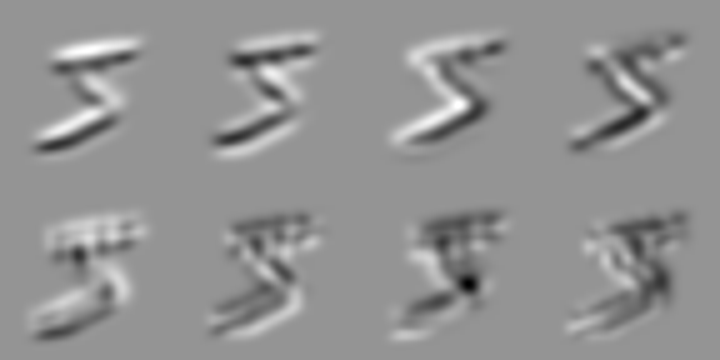

In [100]:
imshow(pca_comp_outs[0],ratio=5)
imshow(pca_comp_outs[1],ratio=5)
imshow(pca_comp_outs[2],ratio=5)
imshow(pca_comp_outs[3],ratio=5)

org_out torch.Size([128, 30, 30])
img size (240, 480)
img size after formatting (240, 480, 3)
(new_width,new_height) (2400, 1200)


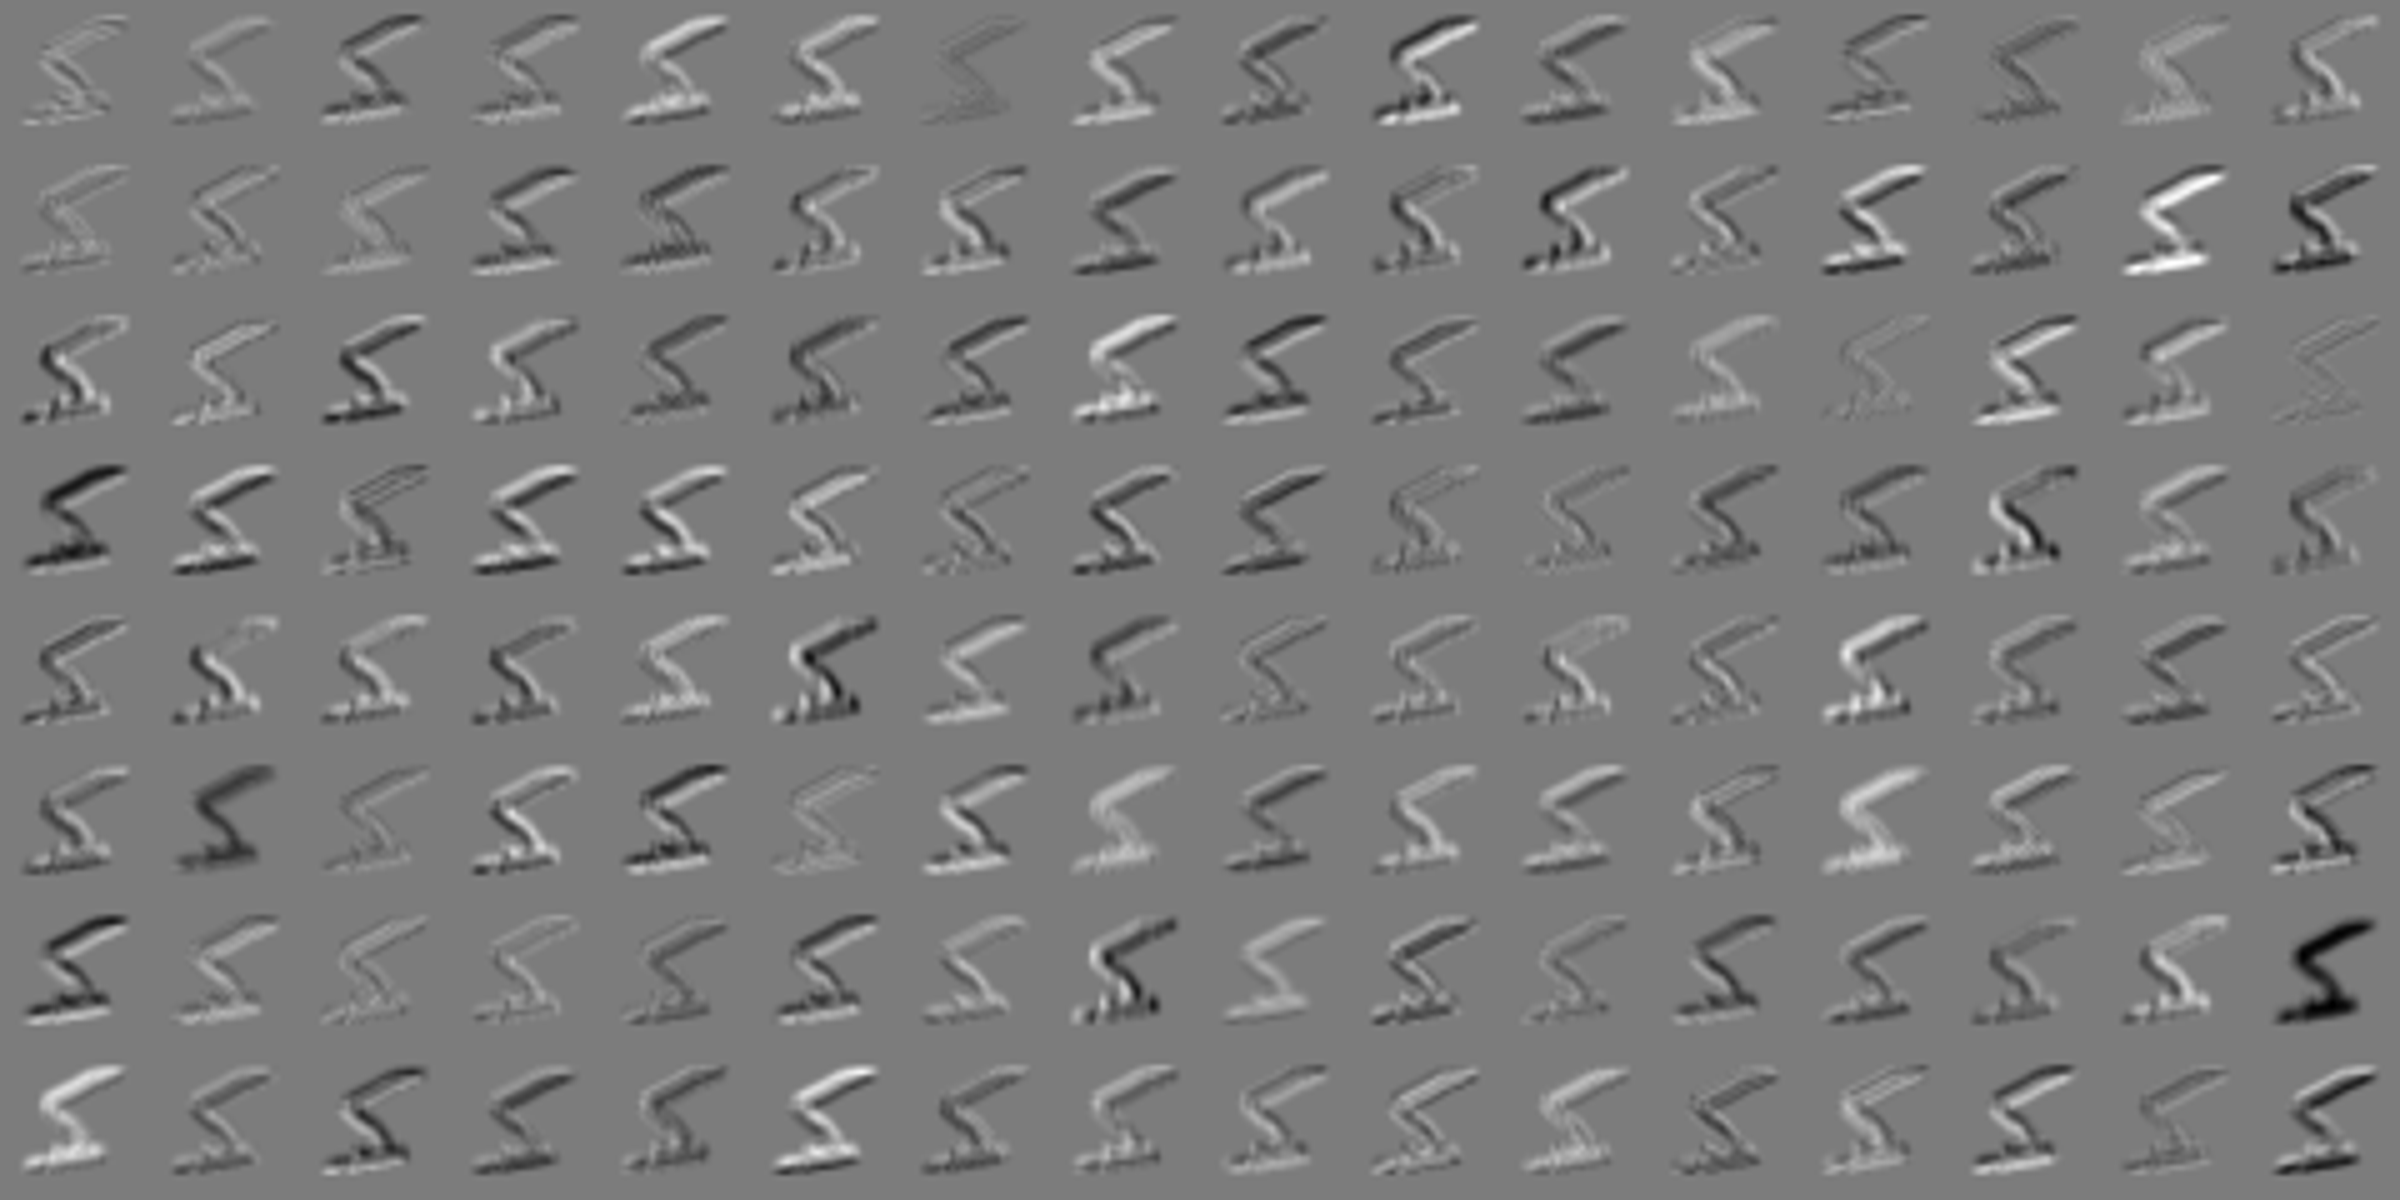

In [101]:
out_capturer = SaveFeatures(custom_model.get_gate_layers_ordered_dict()[key_list[0]])
minput = torch.unsqueeze(sample,0)
minput = torch.unsqueeze(minput,0)
custom_model(minput.to(device))
org_out = out_capturer.features.detach().cpu()[0]
print("org_out",org_out.size())
img_org_out = get_plain_image(org_out,is_standarize=False)
imshow(img_org_out,ratio=5)

org_out torch.Size([128, 32, 32])
img size (256, 512)
img size after formatting (256, 512, 3)
(new_width,new_height) (2560, 1280)


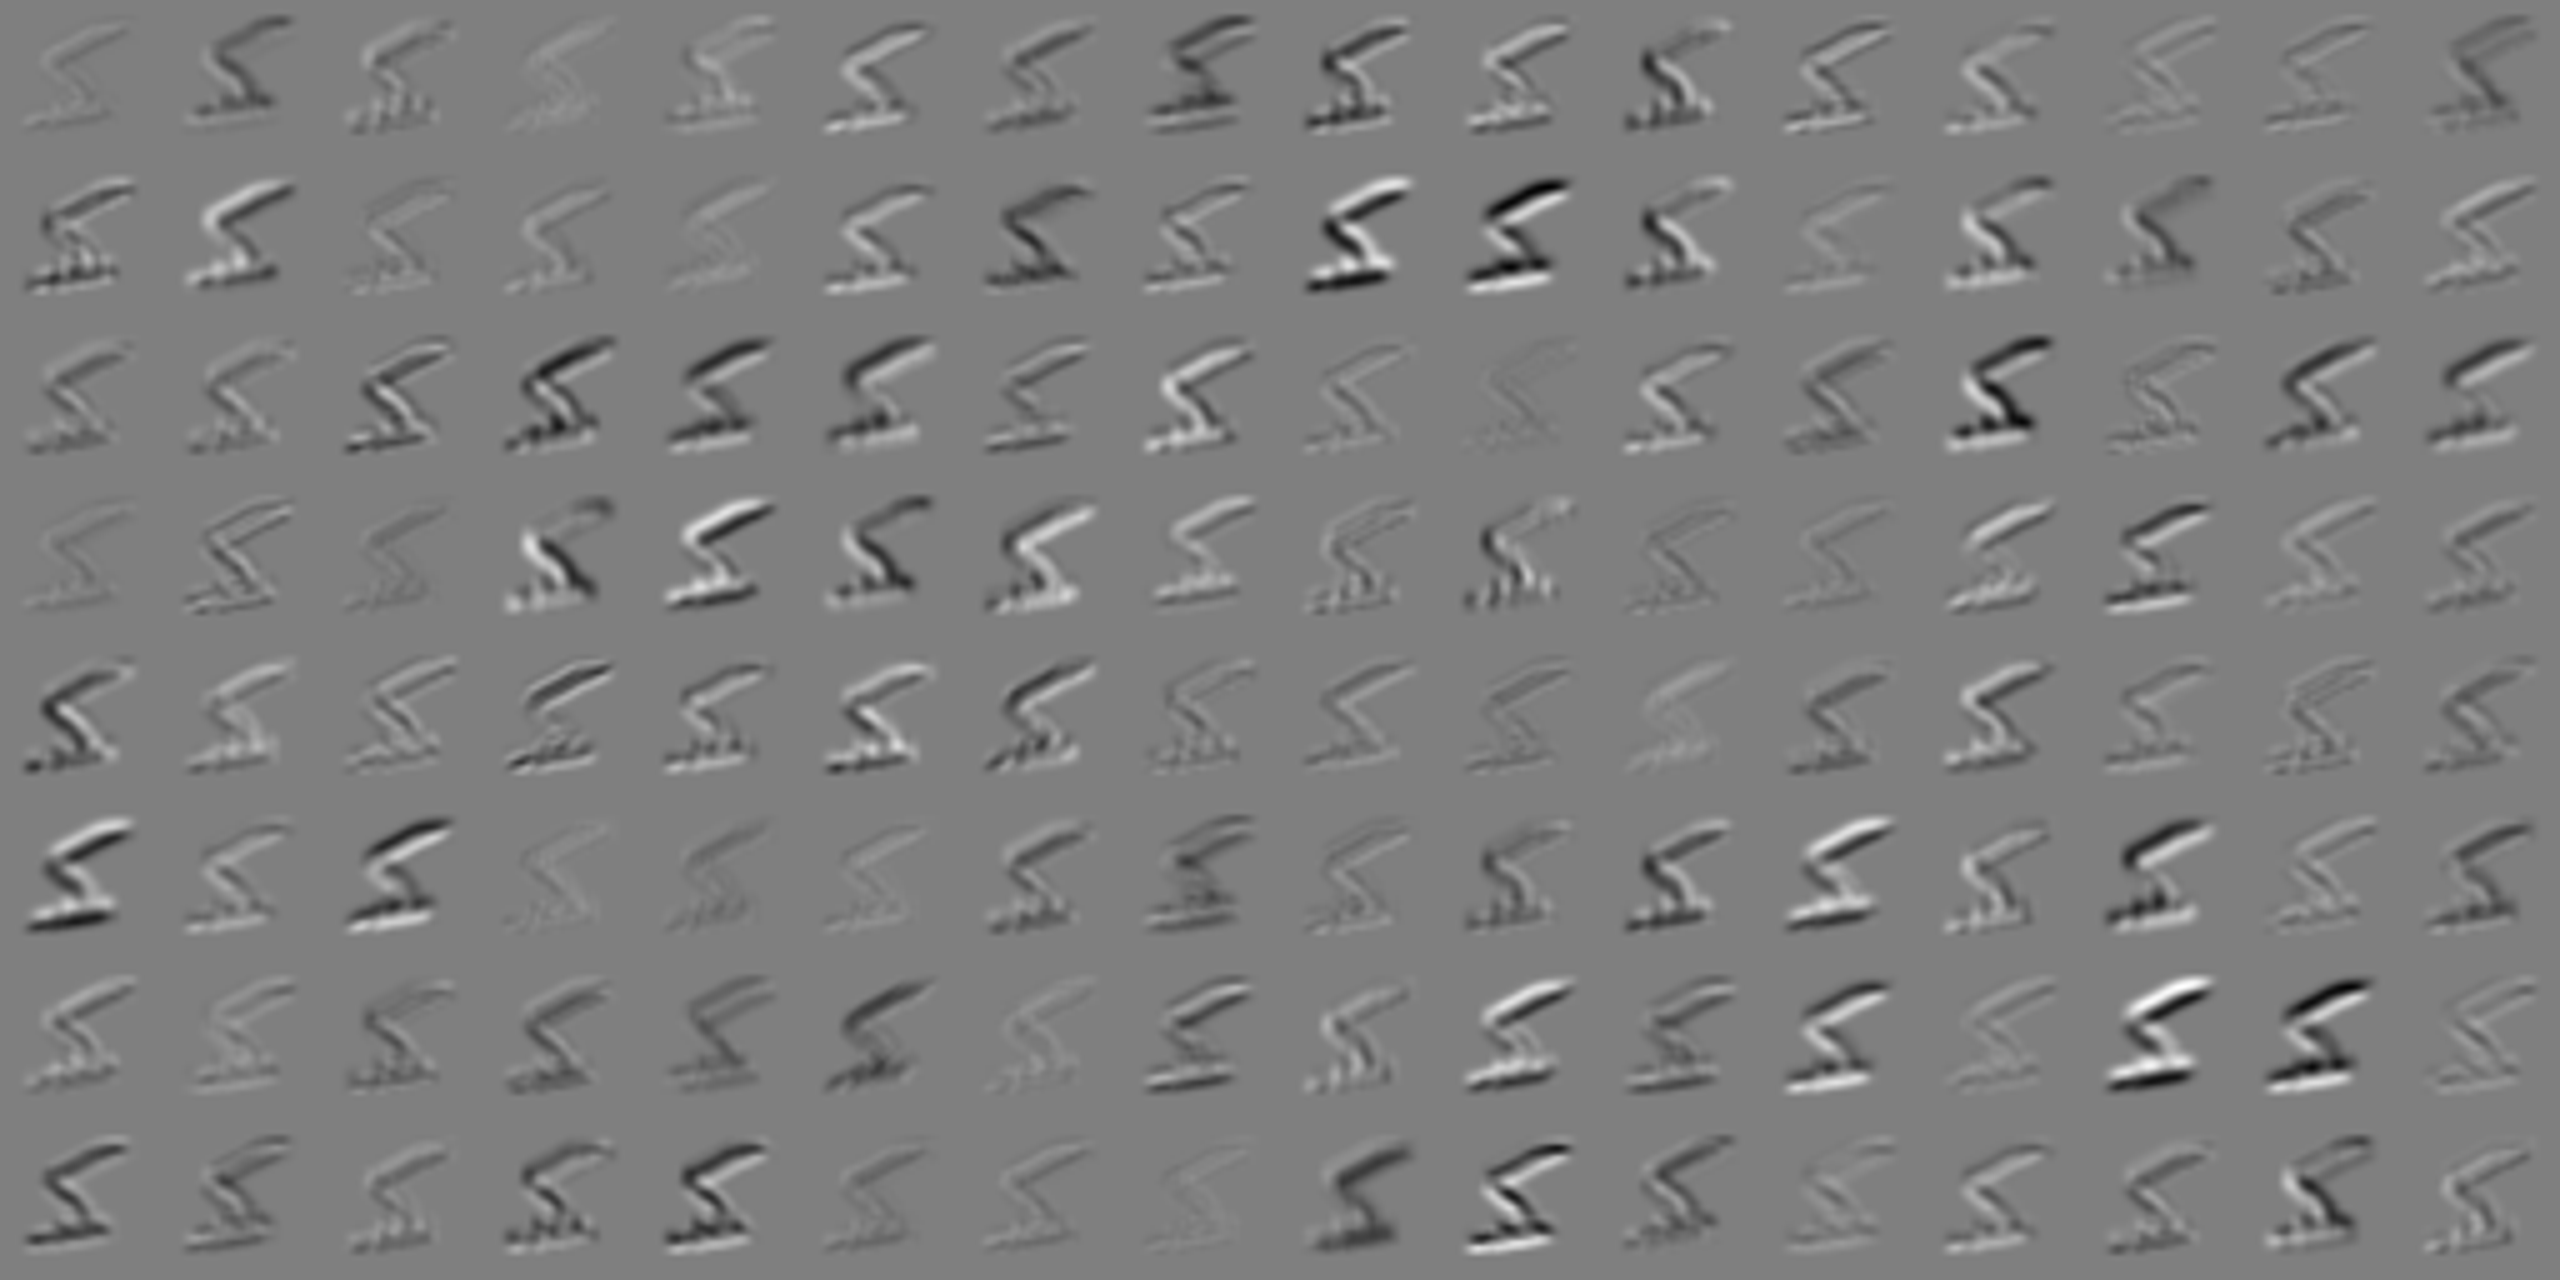

In [102]:
out_capturer = SaveFeatures(custom_model.get_gate_layers_ordered_dict()[key_list[1]])
minput = torch.unsqueeze(sample,0)
minput = torch.unsqueeze(minput,0)
custom_model(minput.to(device))
org_out = out_capturer.features.detach().cpu()[0]
print("org_out",org_out.size())
img_org_out = get_plain_image(org_out,is_standarize=False)
imshow(img_org_out,ratio=5)

org_out torch.Size([128, 34, 34])
img size (272, 544)
img size after formatting (272, 544, 3)
(new_width,new_height) (2720, 1360)


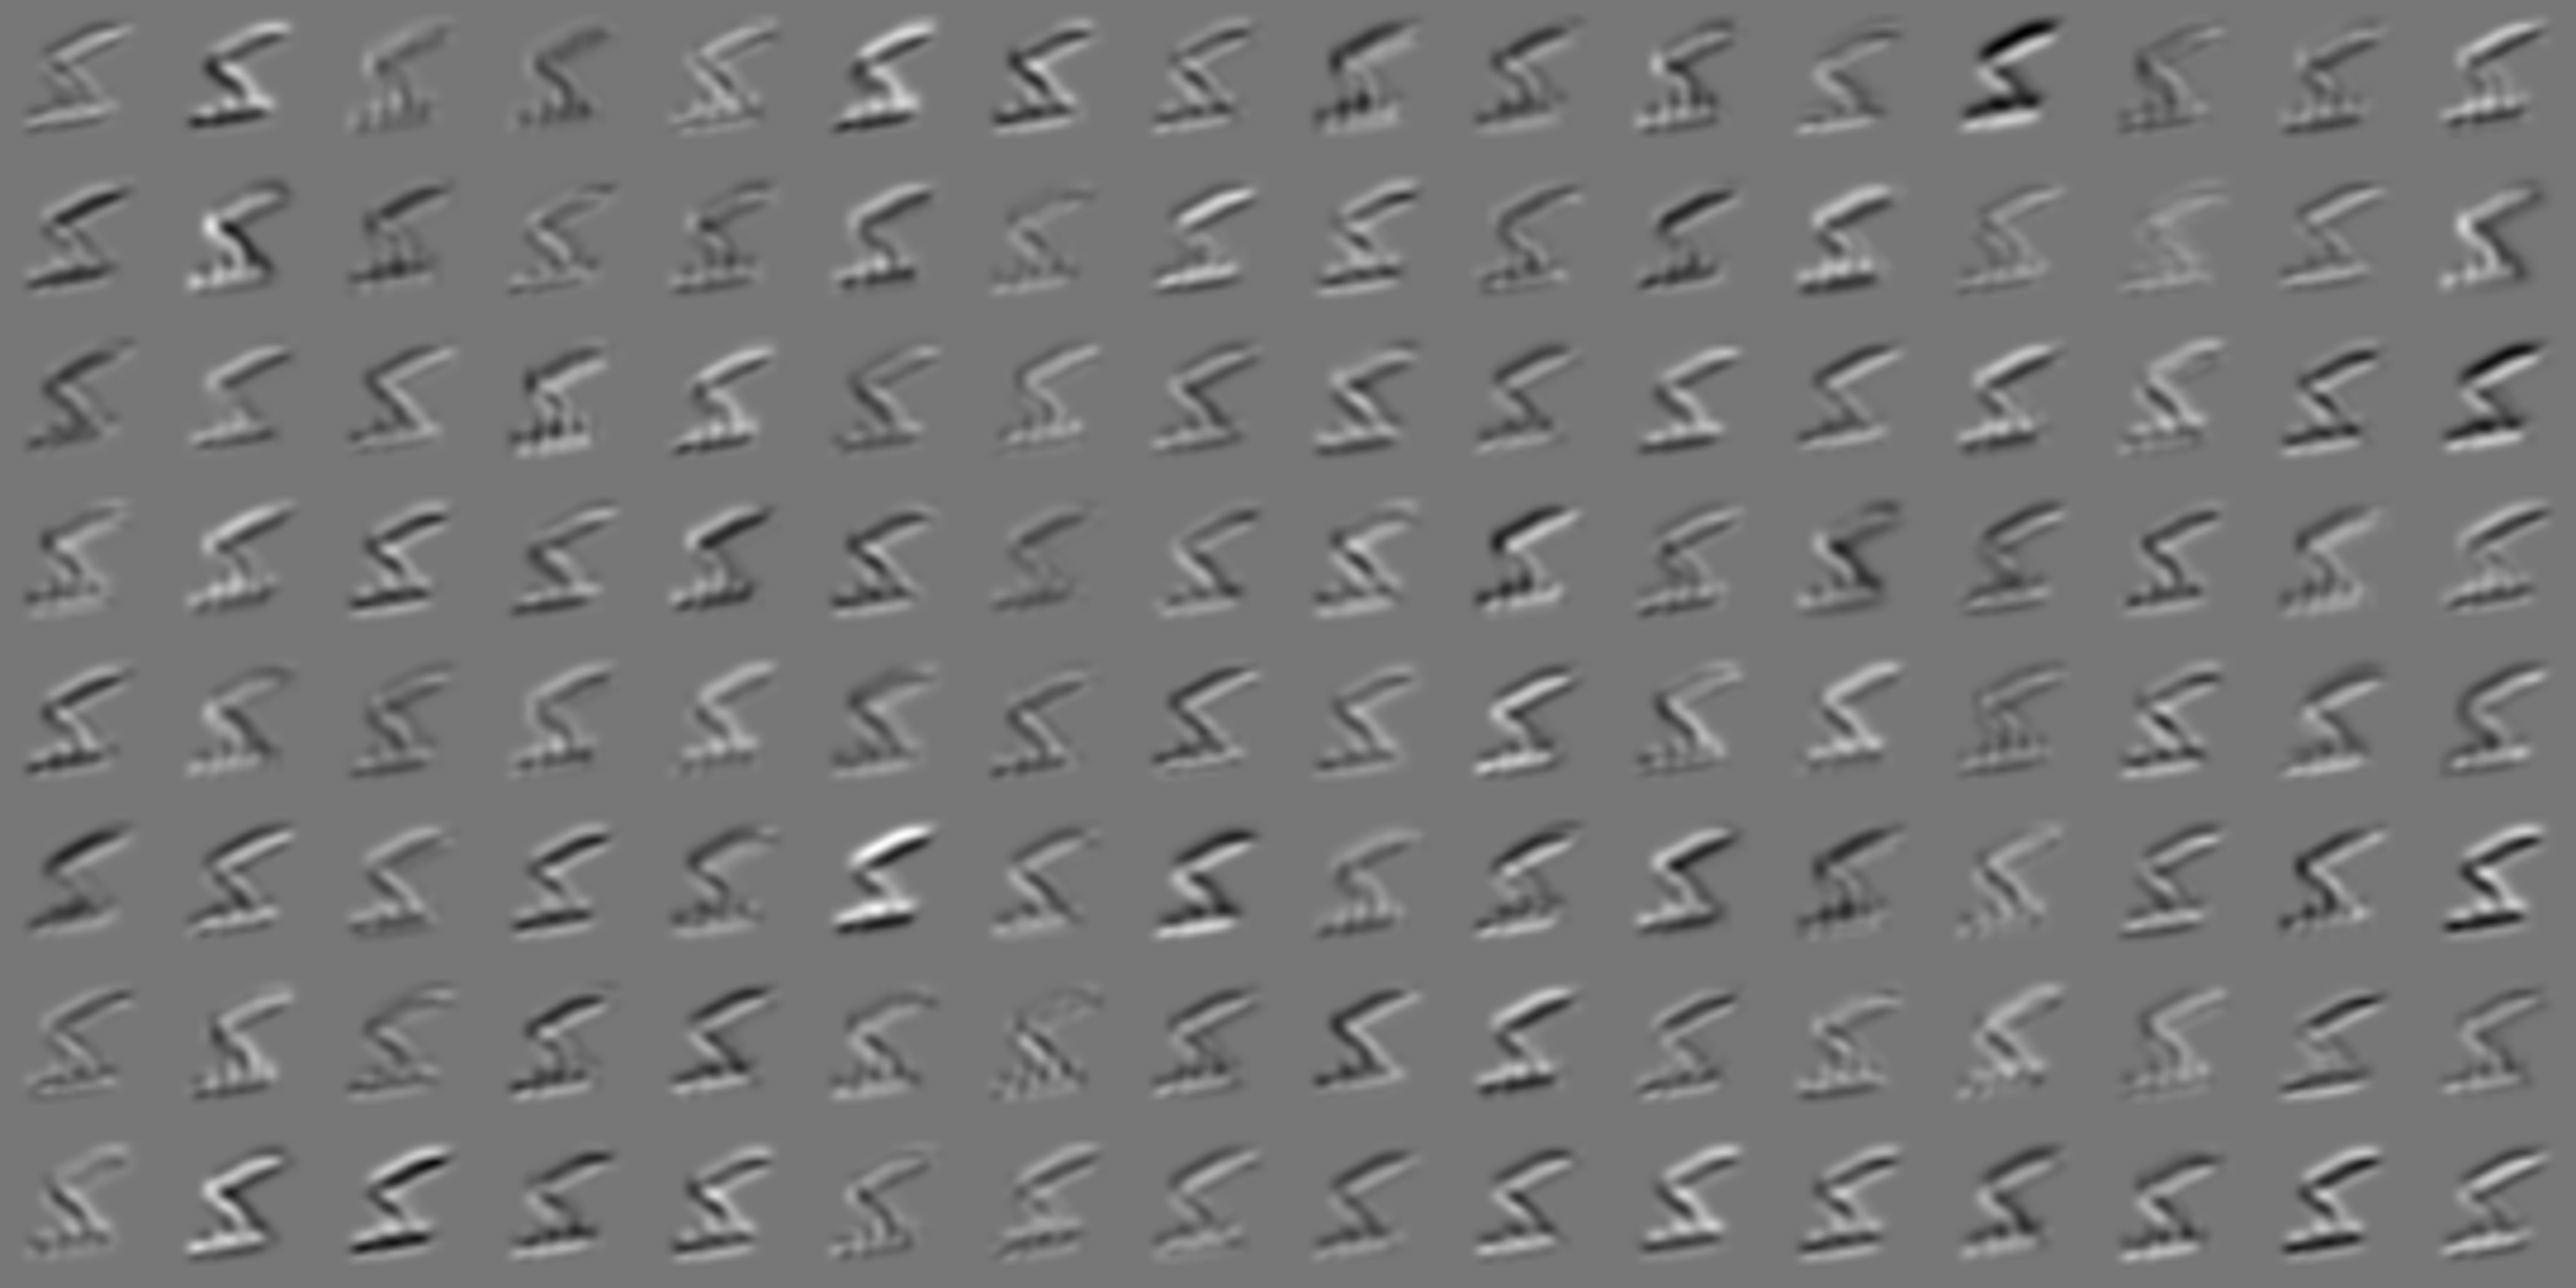

In [103]:
out_capturer = SaveFeatures(custom_model.get_gate_layers_ordered_dict()[key_list[2]])
minput = torch.unsqueeze(sample,0)
minput = torch.unsqueeze(minput,0)
custom_model(minput.to(device))
org_out = out_capturer.features.detach().cpu()[0]
print("org_out",org_out.size())
img_org_out = get_plain_image(org_out,is_standarize=False)
imshow(img_org_out,ratio=5)

org_out torch.Size([128, 36, 36])
img size (288, 576)
img size after formatting (288, 576, 3)
(new_width,new_height) (2880, 1440)


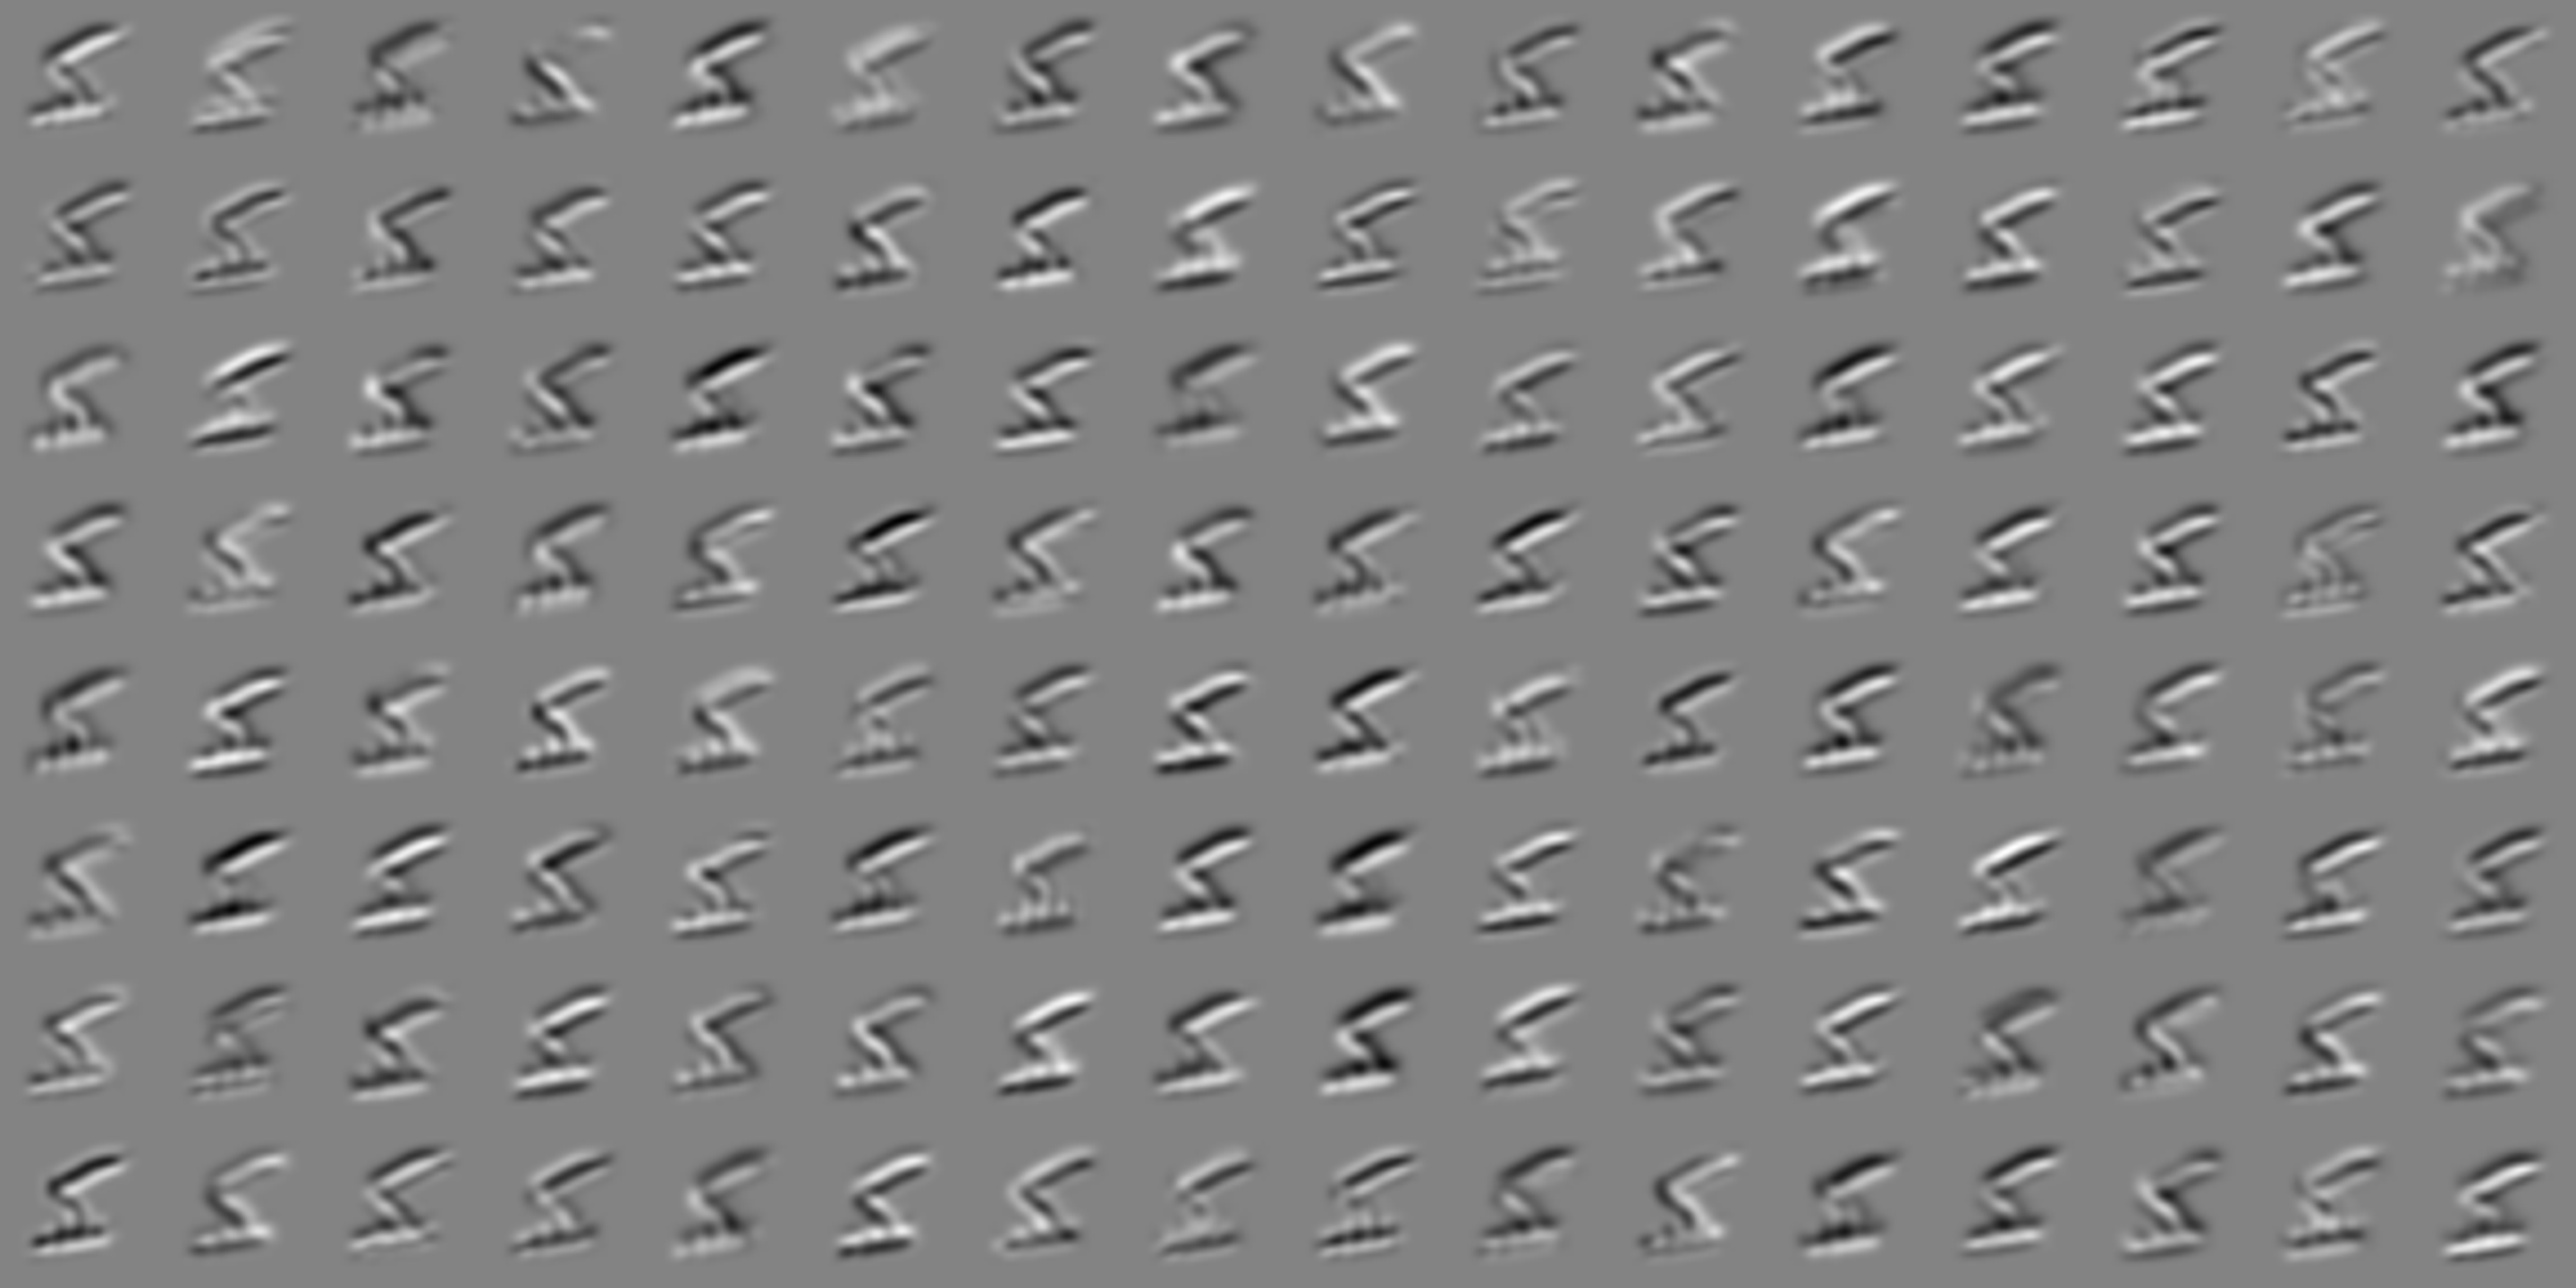

In [104]:
out_capturer = SaveFeatures(custom_model.get_gate_layers_ordered_dict()[key_list[3]])
minput = torch.unsqueeze(sample,0)
minput = torch.unsqueeze(minput,0)
custom_model(minput.to(device))
org_out = out_capturer.features.detach().cpu()[0]
print("org_out",org_out.size())
img_org_out = get_plain_image(org_out,is_standarize=False)
imshow(img_org_out,ratio=5)

In [38]:
def preprocess_image(im_as_arr, normalize=True, resize_im=False):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # Mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Ensure or transform incoming image to PIL image
    # if type(pil_im) != Image.Image:
    #     try:
    #         pil_im = Image.fromarray(pil_im)
    #     except Exception as e:
    #         print("could not transform PIL_img to a PIL Image object. Please check input.")

    # # Resize image
    # if resize_im:
    #     pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    # im_as_arr = np.float32(pil_im)
    # im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    if(normalize):
        # Normalize the channels
        for channel, _ in enumerate(im_as_arr):
            im_as_arr[channel] /= 255
            im_as_arr[channel] -= mean[channel]
            im_as_arr[channel] /= std[channel]

    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten)
    return im_as_var

def blur_img(img, sigma):
    # print("blur img shape", img.shape)
    if sigma > 0:
        img[0] = nd.filters.gaussian_filter(img[0], sigma, order=0)
        # img[1] = nd.filters.gaussian_filter(img[1], sigma, order=0)
        # img[2] = nd.filters.gaussian_filter(img[2], sigma, order=0)
    return img
def recreate_image(im_as_var, unnormalize=True, is_standarize_to_01=True):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [0.4914, 0.4822, 0.4465]
    reverse_std = [1/0.2023, 1/0.1994, 1/0.2010]
    if(isinstance(im_as_var, torch.Tensor)):
        recreated_im = copy.copy(im_as_var.cpu().clone().detach().numpy())
    else:
        recreated_im = im_as_var
    if(len(recreated_im.shape) == 4):
        recreated_im = recreated_im[0]
    if(is_standarize_to_01):
        arr_max = np.amax(recreated_im)
        arr_min = np.amin(recreated_im)
        recreated_im = (recreated_im-arr_min)/(arr_max-arr_min)

    if(unnormalize):
        for c in range(recreated_im.shape[0]):
            recreated_im[c] /= reverse_std[c]
            recreated_im[c] -= reverse_mean[c]
    # recreated_im[recreated_im > 1] = 1
    # recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im)
    # recreated_im = recreated_im..transpose(1, 2, 0)
    return recreated_im

In [39]:
original_image = torch.from_numpy(np.uint8(np.random.random((3, 32, 32)) * 20 + 128.)/255)
# original_image = torch.from_numpy(np.uint8(np.random.uniform(0, 1, (3, 32, 32))))

In [40]:
# tmp=recreate_image(original_image,unnormalize=False)
# tmp = format_np_output(tmp)
# tmp = Image.fromarray(tmp)
# tmp.show()
# plt_imshow(tmp)

In [41]:

start_sigma = 0.75
end_sigma = 0.1
start_step_size = 0.01
end_step_size = 0.05
number_of_image_optimization_steps = 300
initial_image = preprocess_image(
            original_image.cpu().clone().detach().numpy(), normalize=False)
initial_image = initial_image.to(device)
initial_image.requires_grad_()
analyse_layer_ind = 3
loss_fn = torch.nn.CrossEntropyLoss()
labels=[0]*10
labels[0]=1
labels = torch.Tensor(labels).unsqueeze(0).to(device)
print(initial_image.size())
out_capt = SaveFeatures(custom_model.get_gate_layers_ordered_dict()[key_list[analyse_layer_ind]])
optimizer = torch.optim.Adam([initial_image], lr=start_step_size)
pcacomp_conv_arr[analyse_layer_ind] = pcacomp_conv_arr[analyse_layer_ind].to(device)
with trange(number_of_image_optimization_steps, unit="iter", desc="Generating template image for given image V2") as pbar:
    for step_iter in pbar:
        pbar.set_description(f"Iteration {step_iter+1}")
        optimizer.zero_grad()

        # step_size = start_step_size + \
        #     ((end_step_size - start_step_size) * step_iter) / \
        #     number_of_image_optimization_steps

        # sigma = start_sigma + \
        #     ((end_sigma - start_sigma) * step_iter) / \
        #     number_of_image_optimization_steps

        filt_out = pcacomp_conv_arr[analyse_layer_ind](initial_image)
        # outputs = custom_model(initial_image)

        loss = -filt_out.mean()+0.01*torch.norm(initial_image,p=1)
        # loss = -out_capt.features[0].mean()+0.1*torch.norm(initial_image,p=1)
        # loss = loss_fn(outputs, labels)
        # loss = filt_out[100]
        print(loss)

        # Backward
        loss.backward()

        optimizer.step()

        # unnorm_gradients = initial_image.grad

        # # std_unnorm_grad = torch.std(unnorm_gradients)

        # norm_grad = torch.norm(unnorm_gradients)

        # # gradients = unnorm_gradients / first_norm
        # gradients = unnorm_gradients / \
            # norm_grad + 1e-8

        # with torch.no_grad():
        #     # self.initial_image = self.initial_image - gradients*step_size
        #     blurred_grad = gradients.cpu().detach().numpy()[0]
        #     blurred_grad = blur_img(
        #         blurred_grad, sigma)
        #     initial_image = initial_image.cpu().detach().numpy()[
        #         0]
        #     initial_image -= step_size / \
        #         np.abs(blurred_grad).mean() * blurred_grad

        #     initial_image = blur_img(
        #         initial_image, sigma)
        #     initial_image = torch.from_numpy(
        #         initial_image[None])

        # initial_image = initial_image.to(device)
        # initial_image.requires_grad_()

        # pbar.set_postfix(loss=loss.item(), norm_image=torch.norm(
        #     initial_image).item(), norm_grad=torch.norm(gradients).item(), norm_raw_grad=norm_grad.item())

torch.Size([1, 3, 32, 32])


Iteration 1:   0%|          | 0/300 [00:00<?, ?iter/s]                                 

tensor(16.5727, device='cuda:0', grad_fn=<AddBackward0>)


Iteration 49:  16%|█▌        | 47/300 [00:00<00:03, 75.55iter/s]

tensor(16.2655, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.9584, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.6512, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.3440, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.0369, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.7297, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.4225, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.1154, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.8082, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.5010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.1939, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.8867, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.5795, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.2724, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.9652, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.6581, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.3509, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.0437, device='cuda:0'

Iteration 91:  30%|███       | 90/300 [00:01<00:01, 129.77iter/s]

tensor(1.8288, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5216, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2145, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9426, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7428, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5220, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4967, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5116, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5733, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6714, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7543, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7982, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8069, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7840, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7326, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6555, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5594, device='cuda:0', grad_fn=<AddBack

Iteration 136:  45%|████▍     | 134/300 [00:01<00:00, 168.80iter/s]

tensor(0.0897, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0804, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0740, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0721, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0647, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0495, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0537, device='cuda:0', grad_fn=<AddBack

Iteration 183:  60%|██████    | 180/300 [00:01<00:00, 195.38iter/s]

tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0371, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0410, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0342, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0371, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0345, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0351, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0359, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0362, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0407, device='cuda:0', grad_fn=<AddBack

Iteration 225:  75%|███████▍  | 224/300 [00:01<00:00, 200.40iter/s]

tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0350, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0319, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0351, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0313, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0261, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0306, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0336, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0314, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0340, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0340, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0365, device='cuda:0', grad_fn=<AddBack

Iteration 271:  82%|████████▏ | 246/300 [00:01<00:00, 204.46iter/s]

tensor(0.0367, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0349, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0314, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0330, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0335, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0321, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0371, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0354, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0361, device='cuda:0', grad_fn=<AddBack

Iteration 300: 100%|██████████| 300/300 [00:02<00:00, 142.91iter/s]

tensor(0.0337, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0288, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0299, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0353, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0329, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0343, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0381, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0338, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0351, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0370, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0349, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0356, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0369, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0388, device='cuda:0', grad_fn=<AddBack

In [42]:
# pcacomp_conv_arr[analyse_layer_ind].weight[0]

In [43]:
initial_image.max(),initial_image.size()

(tensor(0.0040, device='cuda:0', grad_fn=<MaxBackward1>),
 torch.Size([1, 3, 32, 32]))

In [44]:
initial_image[0][1]

tensor([[-1.1982e-03, -1.4794e-03,  1.6281e-03,  ...,  8.3553e-05,
         -9.8369e-04,  8.3553e-05],
        [ 9.9689e-06,  2.4243e-04, -9.8369e-04,  ..., -7.5074e-04,
          5.7323e-04,  1.8557e-03],
        [ 9.2630e-04,  4.4346e-04,  9.2630e-04,  ...,  9.2630e-04,
         -1.1982e-03, -1.4794e-03],
        ...,
        [ 4.1561e-04,  2.6624e-05, -6.6140e-04,  ..., -6.6140e-04,
          8.3553e-05,  2.6624e-05],
        [-6.6140e-04,  1.8557e-03,  5.7323e-04,  ..., -1.4794e-03,
          5.8875e-04, -9.7087e-04],
        [-2.0111e-04,  1.8312e-03,  1.8557e-03,  ...,  1.8312e-03,
         -8.2481e-04,  4.1561e-04]], device='cuda:0',
       grad_fn=<SelectBackward0>)

torch.Size([1, 3, 32, 32])
npimg size (3, 32, 32)


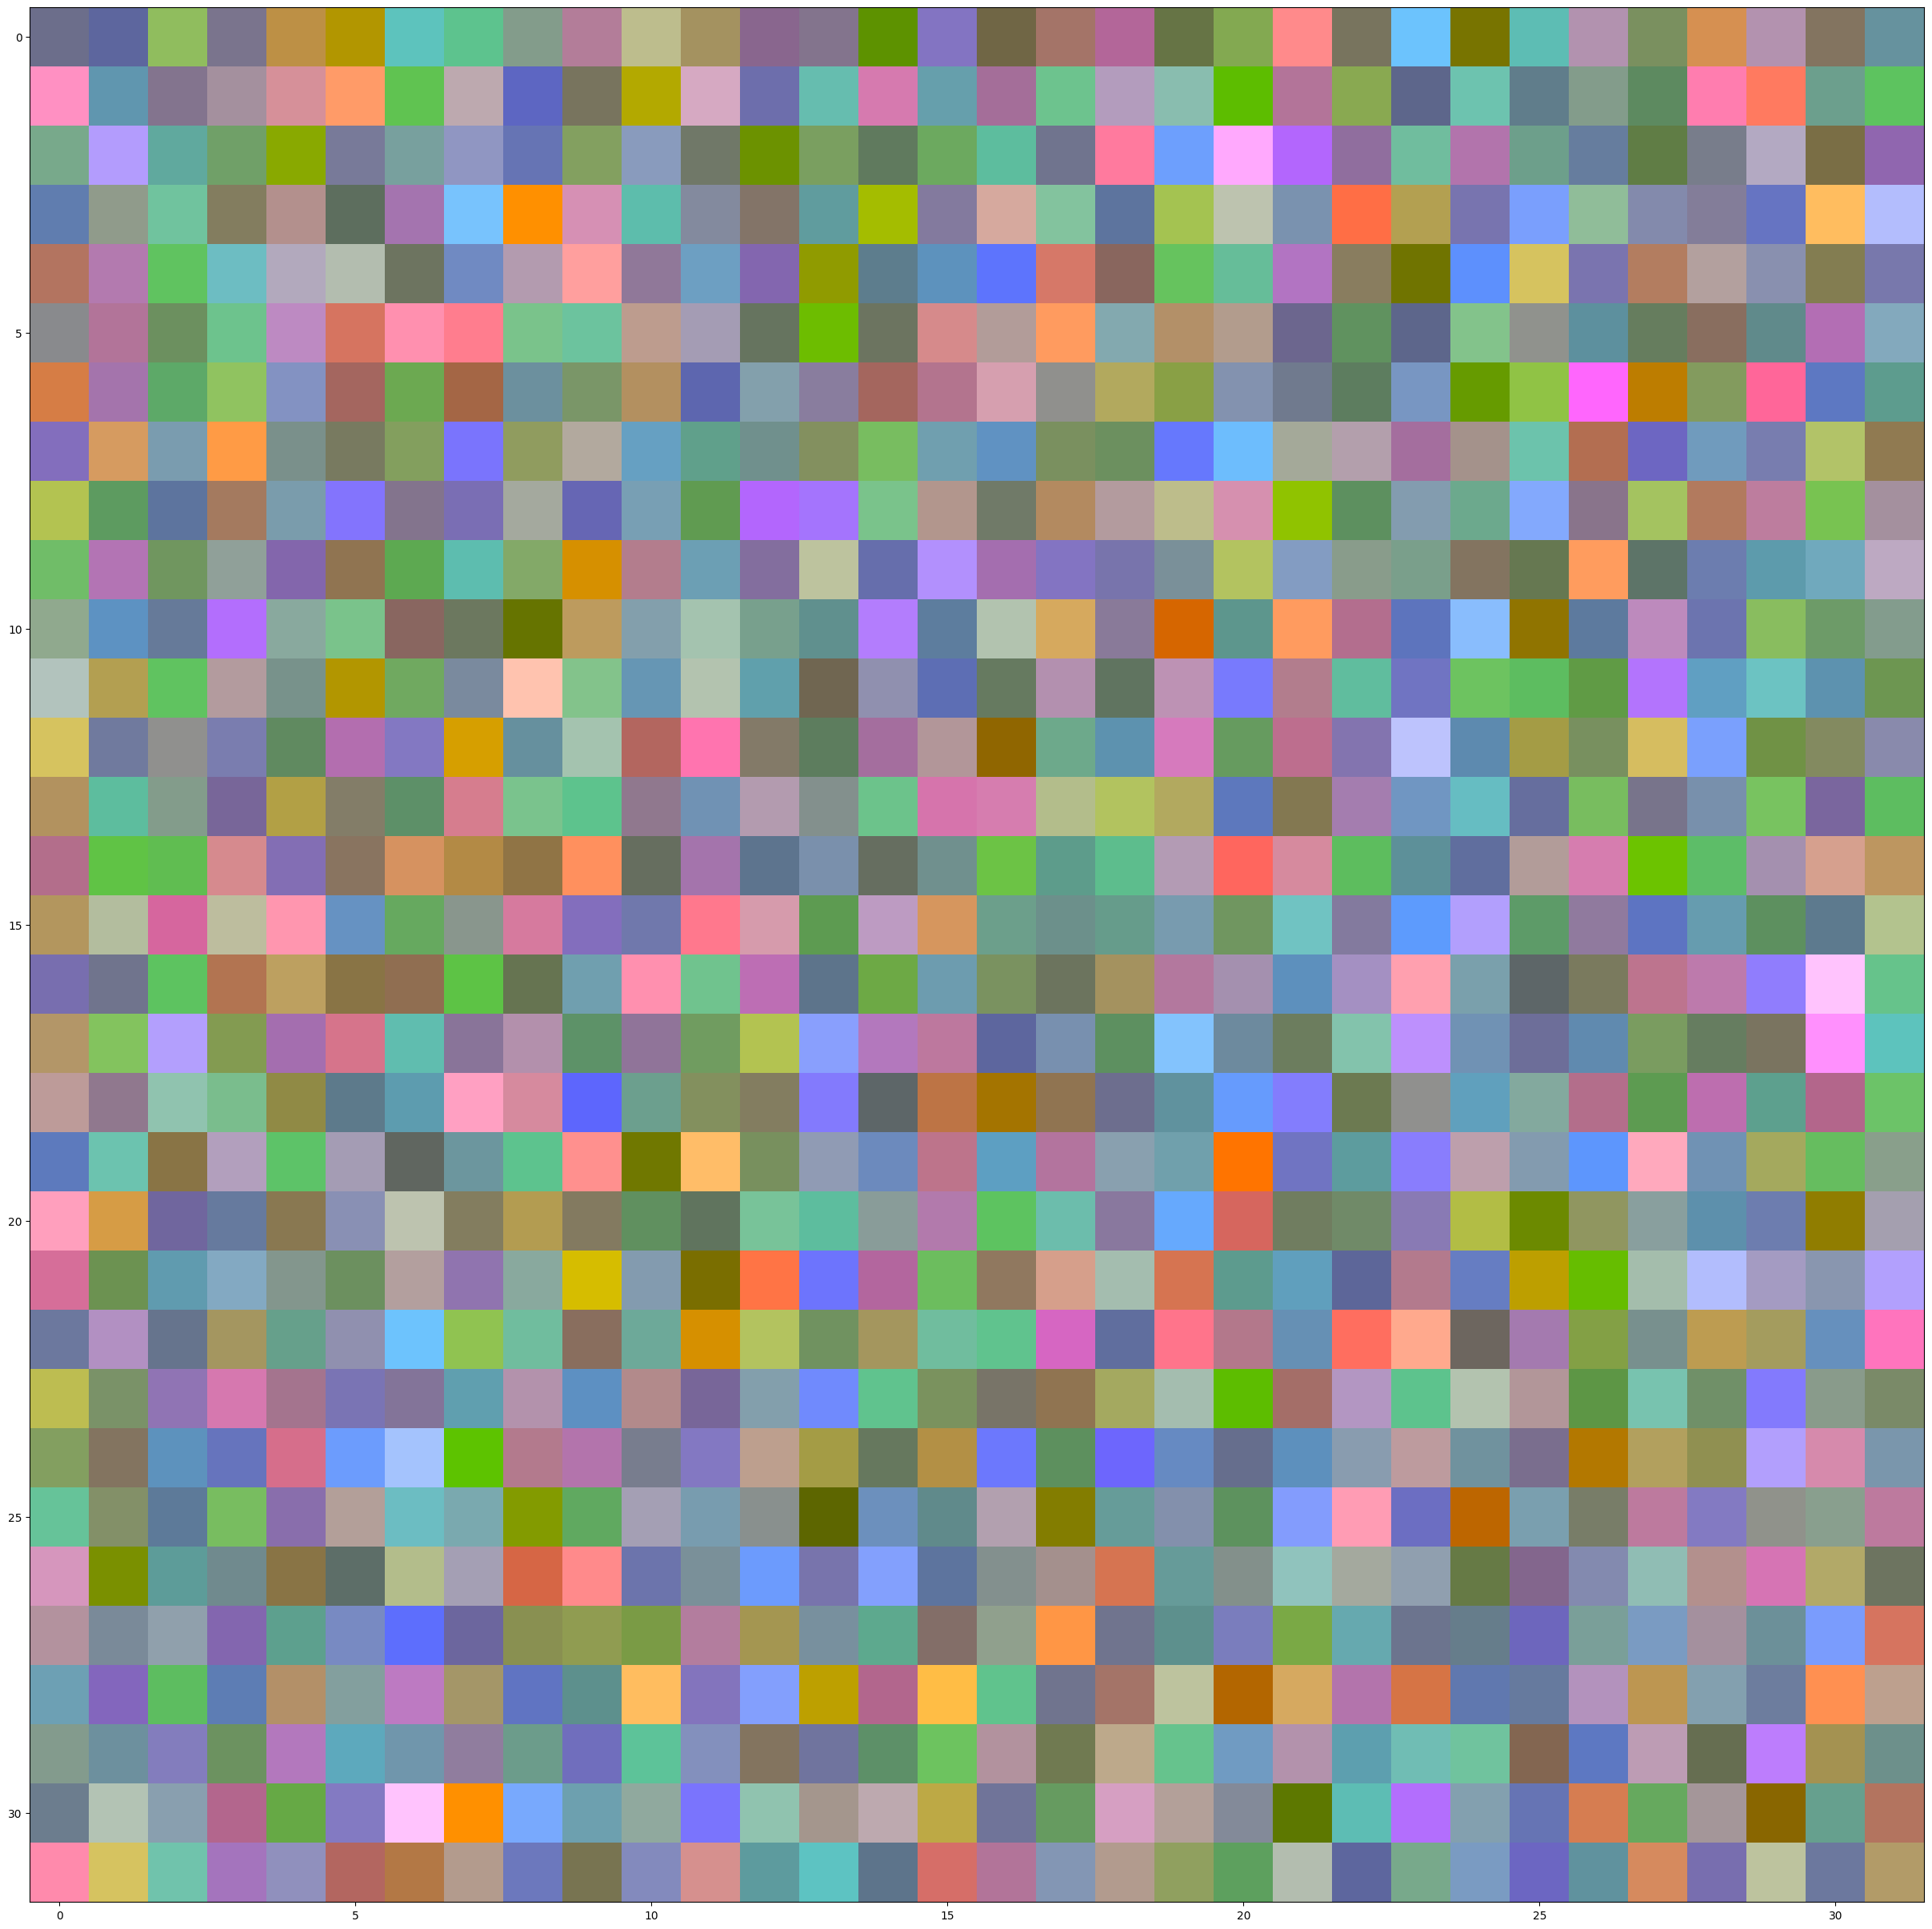

In [45]:
with torch.no_grad():
  print(initial_image.size())
  reconst_image=recreate_image(initial_image,unnormalize=False)
  # reconst_image = format_np_output(reconst_image)
  # reconst_image = Image.fromarray(reconst_image)
  # reconst_image.show()
  plt_imshow(reconst_image)

In [46]:
#custom function to fetch images from dataloader
def show_batch_images(model,dataloader):

  images,_ = next(iter(dataloader))
  images = images.to(device)
  #run the model on the images
  outputs = model(images)

  #get the maximum class
  _, pred = torch.max(outputs.data, 1)

  #make grid
  img = torchvision.utils.make_grid(images)

  #call the function
  show_imshow(img, title=[classes[x.item()] for x in pred])

  return images, pred

In [47]:
def get_prob_no_occ(model,images):
  #running inference on the images without occlusion

  #vgg16 pretrained model
  outputs = model(images)
  print(outputs.shape)

  #passing the outputs through softmax to interpret them as probability
  outputs = nn.functional.softmax(outputs, dim = 1)

  #getting the maximum predicted label
  prob_no_occ, pred = torch.max(outputs.data, 1)

  #get the first item
  prob_no_occ = prob_no_occ[0].item()

  print(prob_no_occ)
  return prob_no_occ

#custom function to conduct occlusion experiments

def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):

    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]

    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))

    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))

    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):

            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)

            if (w_end) >= width or (h_end) >= height:
                continue

            input_image = image.clone().detach()

            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel

            #run inference on modified image
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]

            #setting the heatmap location to probability value
            heatmap[h, w] = prob

    return heatmap

In [48]:
next(custom_model.parameters()).device,next(custom_model.parameters()).dtype

(device(type='cuda', index=0), torch.float32)

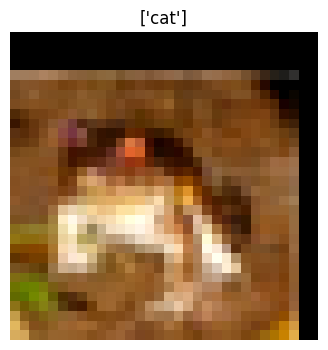

In [49]:
images, pred = show_batch_images(custom_model,trainloader)

In [50]:
heatmap = occlusion(custom_model, images, pred[0].item(), 32, 32)

In [51]:
prob_no_occ = get_prob_no_occ(custom_model,images)
(0,prob_no_occ)

torch.Size([1, 10])
0.4029774069786072


(0, 0.4029774069786072)

In [52]:
#displaying the image using seaborn heatmap and also setting the maximum value of gradient to probability
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
figure = imgplot.get_figure()
figure.savefig('svm_conf.png', dpi=400)

ValueError: ignored